# Behavioral Cloning
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)

## Setup

In [1]:
# Import Libraries
from zipfile import ZipFile
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import util, exposure
from sklearn.utils import shuffle
from tensorflow.keras import models, layers

## Data load
### Get data into the local instance

In [2]:
!wget https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip -O data.zip

with ZipFile('data.zip', 'r') as zipObj:
   zipObj.extractall()
   print('Finish extracting')

--2020-10-05 10:56:20--  https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 54.240.168.228, 54.240.168.138, 54.240.168.210, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|54.240.168.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 333137665 (318M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================&gt;] 317,70M  11,5MB/s    in 29s     

2020-10-05 10:56:50 (10,9 MB/s) - ‘data.zip’ saved [333137665/333137665]

Finish extracting


### Load the log data to be preprocessed

In [3]:
log_data = pd.read_csv('./data/driving_log.csv')
log_data.drop(columns=['throttle','brake','speed'],inplace=True)
print('Size:\t\t',len(log_data))
print('Columns:\t',list(log_data.columns),)
print()

Size:		 8036
Columns:	 [&#39;center&#39;, &#39;left&#39;, &#39;right&#39;, &#39;steering&#39;]



### Data distribution

&lt;AxesSubplot:ylabel=&#39;Frequency&#39;&gt;

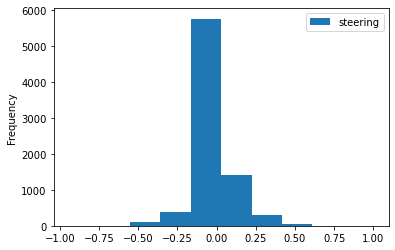

In [4]:
log_data.plot.hist()

## Functions for preprocessing

In [5]:
'''
Gets side cameras to improve driving correction
'''
def get_side_cameras(log_line,correction = 0.25):
    steering_left = log_line.steering + correction
    path_left = './data/'+log_line.left.strip()
    image_left = cv2.imread(path_left)
    image_left = cv2.cvtColor(image_left,cv2.COLOR_BGR2RGB)

    steering_right = log_line.steering - correction
    path_right = './data/'+log_line.right.strip()
    image_right = cv2.imread(path_right)
    image_right = cv2.cvtColor(image_right,cv2.COLOR_BGR2RGB)
    return image_left,steering_left,image_right,steering_right

'''
Loads a batch of images from the log and preprocess the images
'''
def batch_loader(log_select):
    images = []
    measurements = []
    for l in log_select.itertuples():
        path = './data/'+l.center
        image = cv2.imread(path)
        # Fix for udacity simulator
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        if np.random.rand() > .5:
            image = exposure.adjust_gamma(image, np.random.uniform(0.75,1.10))
        images.append(image)
        measure = l.steering
        measurements.append(measure)
        #Include side cameras
        img_left,measure_left,img_right,measure_right = get_side_cameras(l)
        images.append(img_left)
        measurements.append(measure_left)
        images.append(img_right)
        measurements.append(measure_right)
    return np.asarray(images),np.asarray(measurements)

'''
Split the data in train, test and validation
'''
def train_test_val(log_data_frame, train_ratio, test_ratio, val_ratio):
    assert sum([train_ratio, test_ratio, val_ratio])==1.0
    log_data_frame = shuffle(log_data_frame)
    data_size = len(log_data_frame)
    id_train = int(round(data_size*train_ratio))
    id_test = int(round(data_size*(train_ratio+test_ratio)))

    train = log_data_frame[:id_train]
    test = log_data_frame[id_train:id_test]
    validation = log_data_frame[id_test:]
    #print(len(log_data_frame),len(train)+len(test)+len(validation))
    return train, test, validation
'''
Flip images and measure to help with the data distribution to one side
'''
def flip(in_images,in_labels):
    result_images =[]
    result_measures =[]
    for pos,img in enumerate(in_images):
        result_images.append(np.fliplr(img))
        flip_measure = 0.0
        if in_labels[pos] != 0.0:
            flip_measure = - in_labels[pos]
        result_measures.append(flip_measure)
    
    result_images = np.asarray(result_images)
    result_measures = np.asarray(result_measures)
    assert len(in_images)==len(result_images)
    return result_images,result_measures

## Data generator
Function to load a batch at a time in memory

In [6]:
def image_generator(logs, batch_s, training=True):
    while True:
        start = 0
        end = batch_s
        while start  < len(logs):
            selected = logs[start:end]
            images,labels = batch_loader(selected)
            if training:
                flip_img,flip_l = flip(images,labels)
                images = np.vstack((flip_img,images))
                labels = np.hstack((flip_l,labels))
            yield images,labels
            start += batch_size
            end += batch_size

## Verify functions and images

8036 4822 1607 1607
(30, 160, 320, 3) (30,)
-0.06925154 0.06925154
(30, 160, 320, 3) (30, 160, 320, 3) (30,)
(60, 160, 320, 3) (60,)
(160, 320, 3)


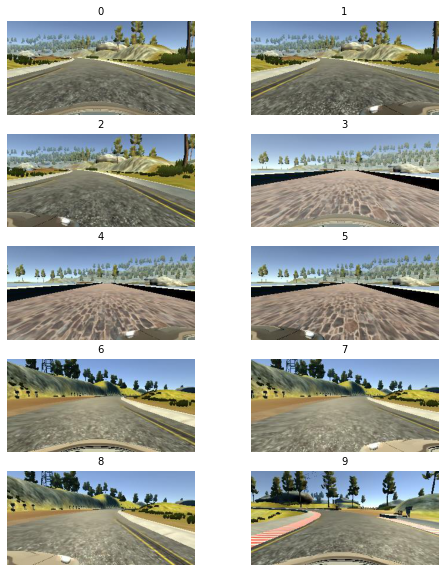

In [7]:
train_log, test_log, validation_log = train_test_val(log_data,0.6,0.2,0.2)
print(len(log_data),len(train_log),len(test_log),len(validation_log))
visualization_images,visualization_labels = batch_loader(train_log[:10])
print(visualization_images.shape,visualization_labels.shape)

flip_images,flip_labels = flip(visualization_images,visualization_labels)
print(visualization_labels[0],flip_labels[0])
print(visualization_images.shape,flip_images.shape,flip_labels.shape)
fig, axes = plt.subplots(5,2, figsize=(8,10))

for i,ax in  enumerate(axes.flat):
    ax.set_title(i,fontsize=10)
    ax.imshow(visualization_images[i])
    ax.set_axis_off()

generator = image_generator(validation_log[0:10],10,training=True)
gen_images,gen_labels=next(generator)
print(gen_images.shape,gen_labels.shape)
img_shape = gen_images[0].shape
batch_size = 32
steps_per_epoch = math.ceil(len(train_log)/batch_size)
validation_steps_per_epoch = math.ceil(len(validation_log)/batch_size)
test_steps_per_epoch = math.ceil(len(test_log)/batch_size)
print(img_shape)

## Neural network architectures

In [8]:
''' Testing keras functionality '''
def simple_net(input_shape):
    m = models.Sequential()
    m.add(layers.Lambda(lambda x: x/127.5-1.,input_shape=input_shape))
    m.add(layers.Cropping2D(cropping=((50,20), (0,0)) ))
    m.add(layers.Convolution2D(24,5,5,activation='relu'))
    m.add(layers.MaxPooling2D())
    m.add(layers.Flatten())
    m.add(layers.Dense(120))
    m.add(layers.Dense(1))
    return m

''' LeNet5 Architecture '''
def le_net_5(input_shape,dropout):
    m = models.Sequential()
    m.add(layers.Lambda(lambda x: x/127.5 - 1., input_shape=input_shape))
    m.add(layers.Convolution2D(64,5,5,activation='relu'))
    m.add(layers.MaxPooling2D((2,2)))
    m.add(layers.Dropout(dropout))
    m.add(layers.Convolution2D(36,5,5,activation='relu'))
    m.add(layers.MaxPooling2D((2,2)))
    m.add(layers.Flatten())
    m.add(layers.Dense(120))
    m.add(layers.Dropout(dropout))
    m.add(layers.Dense(84))
    m.add(layers.Dense(1))
    return m

''' Nvidia proposed network with dropouts '''
def nvidia_model(input_shape,dropout):
    m = models.Sequential()
    m.add(layers.Lambda(lambda x: x/255.0-0.5,input_shape=input_shape))
    m.add(layers.Cropping2D(cropping=((70,25), (0,0))))
    m.add(layers.Convolution2D(24,5,2,activation='relu'))
    m.add(layers.Convolution2D(36,5,2,activation='relu'))
    m.add(layers.Convolution2D(48,5,2,activation='relu'))
    m.add(layers.Dropout(dropout))
    m.add(layers.Convolution2D(64,3,activation='relu'))
    m.add(layers.Convolution2D(64,3,activation='relu'))
    m.add(layers.Flatten())
    m.add(layers.Dense(100))
    m.add(layers.Dropout(dropout))
    m.add(layers.Dense(50))
    m.add(layers.Dense(10))
    m.add(layers.Dense(1))
    return m

Network training

Epoch 1/10
151/151 [==============================] - 86s 567ms/step - loss: 0.0282 - accuracy: 0.1809 - val_loss: 0.0229 - val_accuracy: 0.1830
Epoch 2/10
151/151 [==============================] - 84s 559ms/step - loss: 0.0225 - accuracy: 0.1809 - val_loss: 0.0206 - val_accuracy: 0.1830
Epoch 3/10
151/151 [==============================] - 84s 555ms/step - loss: 0.0210 - accuracy: 0.1808 - val_loss: 0.0196 - val_accuracy: 0.1830
Epoch 4/10
151/151 [==============================] - 85s 565ms/step - loss: 0.0201 - accuracy: 0.1809 - val_loss: 0.0191 - val_accuracy: 0.1830
Epoch 5/10
151/151 [==============================] - 88s 585ms/step - loss: 0.0194 - accuracy: 0.1809 - val_loss: 0.0186 - val_accuracy: 0.1830
Epoch 6/10
151/151 [==============================] - 88s 583ms/step - loss: 0.0187 - accuracy: 0.1809 - val_loss: 0.0183 - val_accuracy: 0.1830
Epoch 7/10
151/151 [==============================] - 88s 586ms/step - loss: 0.0178 - accuracy: 0.1809 - val_loss: 0.0184 - val_ac

[&lt;matplotlib.lines.Line2D at 0x7f3e1538ea90&gt;]

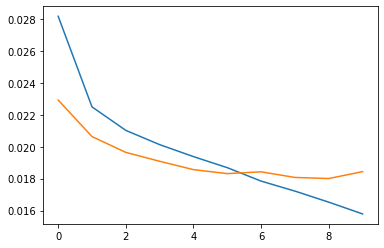

In [9]:
# model = simple_net(img_shape,0.001)
# model = LeNet5(img_shape,0.25,0.0003)
learning_rate = 0.0003
epochs = 10
model = nvidia_model(img_shape,0.25)
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate),metrics=['accuracy'])
history = model.fit(image_generator(train_log,batch_size),
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=image_generator(validation_log,128,training=False),
                    validation_steps=validation_steps_per_epoch,
                    shuffle=True,
                    verbose=1)
print()
print('Plot the loss and the accuracy')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## Evaluate and save the model

In [10]:
scores = model.evaluate(image_generator(test_log,128,training=False),
                        verbose=1,
                        steps=test_steps_per_epoch)
print(scores)
model.save('model.h5')

51/51 [==============================] - 25s 489ms/step - loss: 0.0188 - accuracy: 0.1792
[0.01880875788629055, 0.17922814190387726]
